# Welche Unterschiede gibt es zwischen den Ländern?

In [1]:
# Import
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
path_data = '/home/jm/Desktop/Gamestar_Data/Country_Games/'
path_files = sorted([os.path.join(path_data, file) for file in os.listdir(path_data)])

In [3]:
df = pd.concat([pd.read_csv(file).assign(date=datetime.strptime(file.rsplit('/', 1)[-1].split('_', 1)[0], '%Y-%m-%d')) for file in path_files])

In [4]:
df_country = df.set_index('App_ID').dropna().reset_index().set_index('date')
df_country.shape

(813167, 9)

# Gruppieren nach Land und Game

In [5]:
df_best = df_country.groupby(['Country','Name']).agg({'Rank':'mean'})['Rank'].groupby(level=0, group_keys=False).apply(lambda x: x.sort_values().head(1)).reset_index()
df_best.head(2)

,Country,Name,Rank
0,Afghanistan,Counter-Strike: Global Offensive,1.000000
1,Aland Islands,PLAYERUNKNOWN'S BATTLEGROUNDS,1.171779


In [6]:
n_games = 6

best_games = df_best['Name'].value_counts()[:n_games].index
df_plot = df_best.set_index('Name').loc[best_games].reset_index()[['Country', 'Name']].set_index('Country')
df_plot.head(2)

,Name
Country,
Afghanistan,Counter-Strike: Global Offensive
Albania,Counter-Strike: Global Offensive


In [7]:
unique_values = df_plot['Name'].unique()
unique_values

array(['Counter-Strike: Global Offensive', 'Dota 2',
       "PLAYERUNKNOWN'S BATTLEGROUNDS"], dtype=object)

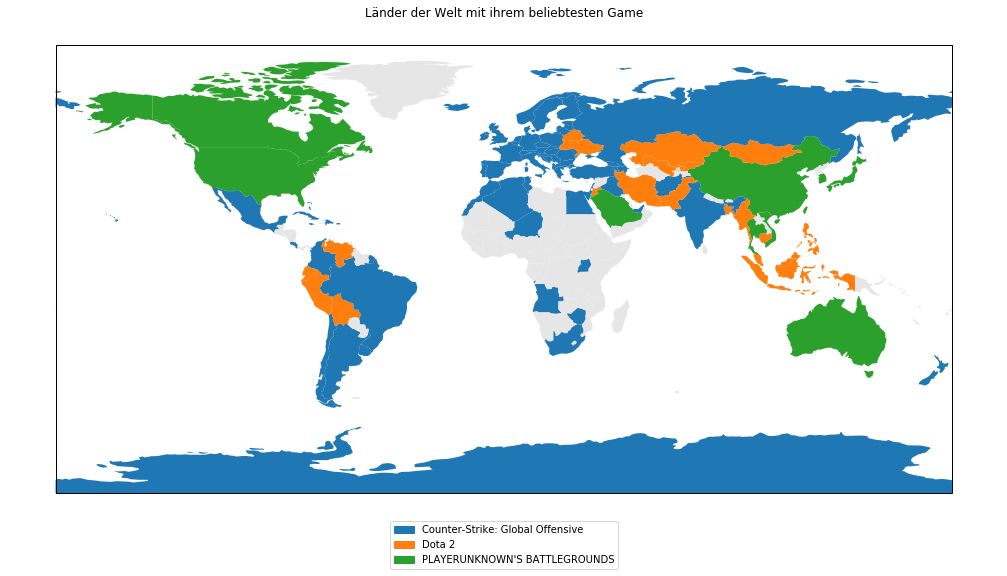

In [8]:
from matplotlib import cm
colors = {name:cm.tab10(i) for i, name in enumerate(unique_values)}

names_map = {'Bahamas':'Bahamas the', 'Republic of Korea':'Korea', 'Kyrgyzstan':'Kyrgyz Republic', 'Russian Federation':'Russia'}


import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import patches
import cartopy.io.shapereader as shpreader
import itertools
import numpy as np

shapename = 'admin_0_countries'
countries_shp = shpreader.natural_earth(resolution='110m',
                                        category='cultural', name=shapename)

plt.figure(figsize=(14,10))
ax = plt.axes(projection=ccrs.PlateCarree())
for country in shpreader.Reader(countries_shp).records():
    country_name = country.attributes['NAME_LONG']
    if country_name in names_map.keys():
        country_name = names_map[country_name]
    ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                      facecolor=colors[df_plot.loc[country_name].values[0]] if country_name in df_plot.index else [0.9, 0.9, 0.9],
                      label=country.attributes['NAME_LONG'])

patches = [patches.Patch(color=color, label=game) for game, color in colors.items()]
plt.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, 0))

plt.title('Länder der Welt mit ihrem beliebtesten Game')
plt.tight_layout()
plt.savefig('Grafiken/17_Länder_mit_ihrem_beliebtesten_Game.pdf')
plt.show()

df_plot.sort_index().to_csv('Tabellen/17_Länder_mit_ihrem_beliebtesten_Game.csv')

# Gruppieren nach Land: Spielzeit

In [9]:
df_duration = df_country.groupby(['Country', 'Name']).agg({'Average_Hours_2_Weeks':'mean', 'Average_Hours_Total':'mean'}).reset_index().groupby('Country').agg({'Average_Hours_2_Weeks':'mean', 'Average_Hours_Total':'mean'})
df_duration.head(2)

,Average_Hours_2_Weeks,Average_Hours_Total
Country,,
Afghanistan,341.669664,2384.735886
Aland Islands,176.475320,1478.635348


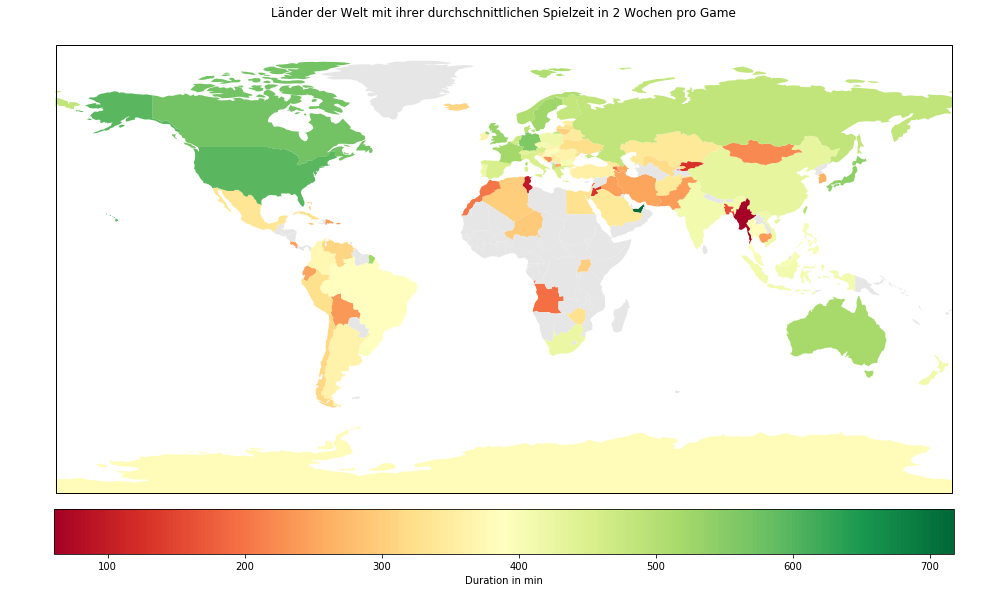

In [10]:
import matplotlib
import matplotlib.cm as cm

column = 'Average_Hours_2_Weeks'

minima = df_duration[column].min()
maxima = df_duration[column].max()

norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.RdYlGn)


names_map = {'Bahamas':'Bahamas the', 'Republic of Korea':'Korea', 'Kyrgyzstan':'Kyrgyz Republic', 'Russian Federation':'Russia'}


import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.io.shapereader as shpreader
import itertools
import numpy as np

shapename = 'admin_0_countries'
countries_shp = shpreader.natural_earth(resolution='110m',
                                        category='cultural', name=shapename)

fig = plt.figure(figsize=(14,10))
ax = plt.axes(projection=ccrs.PlateCarree())
for country in shpreader.Reader(countries_shp).records():
    country_name = country.attributes['NAME_LONG']
    if country_name in names_map.keys():
        country_name = names_map[country_name]
    ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                      facecolor=mapper.to_rgba(df_duration.loc[country_name][column]) if country_name in df_plot.index else [0.9, 0.9, 0.9],
                      label=country.attributes['NAME_LONG'])


mapper.set_array(df_duration[column].values)
cb = plt.colorbar(mapper, orientation='horizontal', pad=-0.01, shrink=0.9125)
cb.set_label('Duration in min')

plt.title('Länder der Welt mit ihrer durchschnittlichen Spielzeit in 2 Wochen pro Game')
plt.tight_layout()
plt.savefig('Grafiken/18_Länder_mit_ihrer_durchschnittlichen_Spielzeite_in_2_Wochen_pro_Game.pdf')
plt.show()

df_plot.sort_index().to_csv('Tabellen/18_Länder_mit_ihrer_durchschnittlichen_Spielzeite_in_2_Wochen_pro_Game.csv')

# Beste Games in Deutschland Evolution

Text(0.5,0,'')

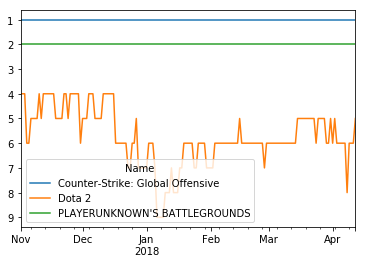

In [11]:
game = ['Counter-Strike: Global Offensive', 'Dota 2', "PLAYERUNKNOWN'S BATTLEGROUNDS"]
df_country[(df_country['Country']=='Germany') & (df_country['Name'].isin(game))][['Rank', 'Name']].reset_index().pivot(index='date', columns='Name', values='Rank').plot()
plt.gca().invert_yaxis()
plt.xlabel('')